In [491]:
%%time

# import libraries used in this project 

import os
import fnmatch
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2,SelectPercentile
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
# configure matplot to not warn on large data set 
plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

Wall time: 1.99 ms


In [492]:
%%time
dataframe = pd.read_csv (r'music_dataframe.csv')
dataframe['zero'] = dataframe['zero'].astype(float)
dataframe=dataframe.replace(to_replace ="artifact",value ="abnormal")
dataframe=dataframe.replace(to_replace ="extrastole",value ="abnormal")
dataframe=dataframe.replace(to_replace ="murmur",value ="abnormal")
# print data frame
dataframe.head()
dataframe["outputbeatclassifier"].unique()

Wall time: 17.3 ms


array(['normal', 'abnormal'], dtype=object)

In [493]:
%%time
# statistically describe librosa features
columnsToDescribe=["zero","centroid","rolloff","chromagram"]
dataframe[columnsToDescribe].describe()

Wall time: 27.3 ms


,zero,centroid,rolloff,chromagram
count,585.000000,585.000000,585.000000,585.000000
mean,4062.259829,593.459736,1163.797054,0.663512
std,8735.425918,840.006987,1452.608685,0.079439
min,161.000000,101.834424,74.468994,0.115923
25%,958.000000,266.161344,543.713379,0.643089
50%,1529.000000,323.542573,676.552012,0.681797
75%,2502.000000,415.151187,860.391899,0.707757
max,75315.000000,6769.973347,8923.169963,0.806292


In [494]:
%%time
# statistically describe frequencies
freqColums=["Freq"+str(i) for i in range(20)]
dataframe[freqColums].describe()

Wall time: 110 ms


,Freq0,Freq1,Freq2,Freq3,Freq4,Freq5,Freq6,Freq7,Freq8,Freq9,Freq10,Freq11,Freq12,Freq13,Freq14,Freq15,Freq16,Freq17,Freq18,Freq19
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000
mean,-405.757946,170.079428,54.052007,-1.498439,1.345889,27.155482,20.358246,2.652989,-3.246019,10.722109,13.194057,4.294947,-5.005561,0.597928,5.872527,4.242858,-2.246271,-0.726721,3.581544,4.159655
std,93.353767,48.520015,26.297832,23.266973,12.645158,9.634136,12.516750,9.144572,8.266007,6.241936,10.146853,4.716163,4.521289,3.401845,6.309628,3.699300,4.221884,3.813255,4.734485,3.515664
min,-1081.043335,-29.527250,-72.262596,-53.103825,-28.883732,-31.063078,-44.440163,-43.664692,-49.969437,-38.816525,-31.041985,-35.024479,-22.014156,-18.243839,-20.437279,-14.023951,-13.795611,-25.276119,-16.287870,-11.521476
25%,-443.315155,155.420853,52.296009,-17.343857,-5.253887,22.754147,19.233067,-1.925813,-7.692395,8.333854,12.741400,2.292238,-7.601873,-1.298143,5.311940,2.965489,-4.529719,-2.209787,2.712182,3.098541
50%,-403.216949,177.656403,62.453419,-4.244802,0.300408,27.771647,23.946444,2.696302,-2.829227,11.513292,16.187937,5.078257,-5.150558,0.380347,7.603932,5.057027,-2.086371,-0.976935,4.631459,5.032918
75%,-365.044312,199.055924,68.766457,8.346755,5.557584,33.162655,27.599564,7.811433,1.094737,14.004535,18.846331,7.108112,-2.797366,1.936331,9.408846,6.316283,-0.114404,0.263281,5.920696,6.155967
max,130.121475,271.676331,91.316147,62.930393,48.075516,50.836891,48.271702,38.122517,20.969564,24.214865,27.890099,23.331343,23.732828,29.896132,43.768089,27.439344,47.039963,50.584553,39.139015,32.866734


In [495]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Freq0                 585 non-null    float64
 1   Freq1                 585 non-null    float64
 2   Freq2                 585 non-null    float64
 3   Freq3                 585 non-null    float64
 4   Freq4                 585 non-null    float64
 5   Freq5                 585 non-null    float64
 6   Freq6                 585 non-null    float64
 7   Freq7                 585 non-null    float64
 8   Freq8                 585 non-null    float64
 9   Freq9                 585 non-null    float64
 10  Freq10                585 non-null    float64
 11  Freq11                585 non-null    float64
 12  Freq12                585 non-null    float64
 13  Freq13                585 non-null    float64
 14  Freq14                585 non-null    float64
 15  Freq15                5

Wall time: 1.76 s


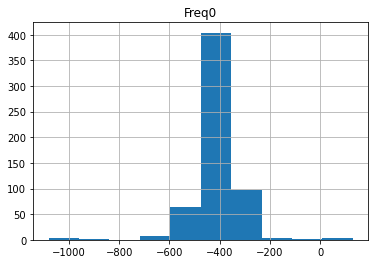

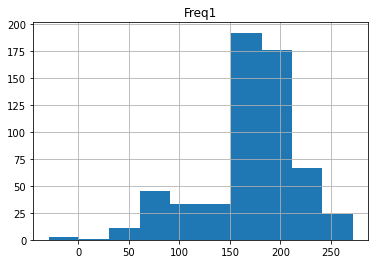

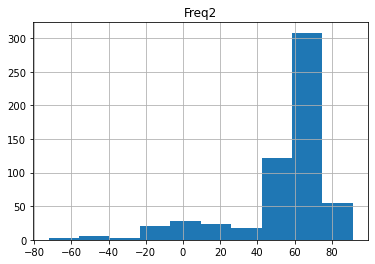

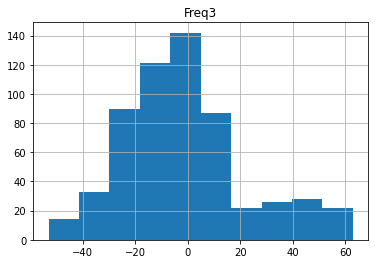

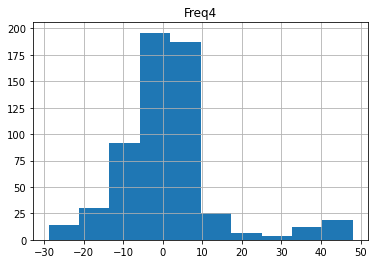

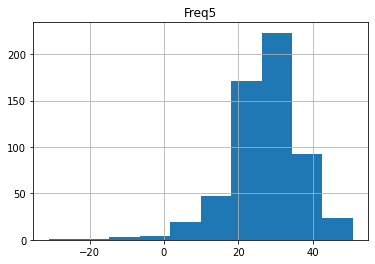

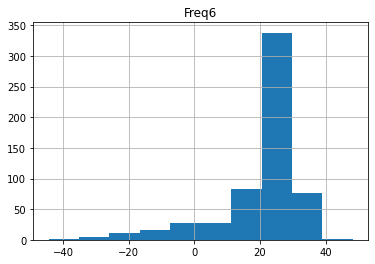

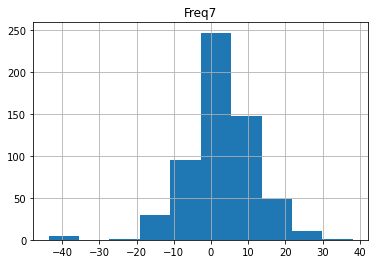

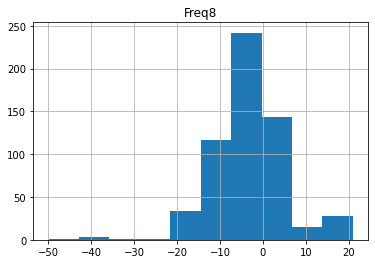

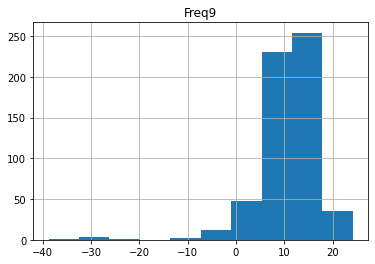

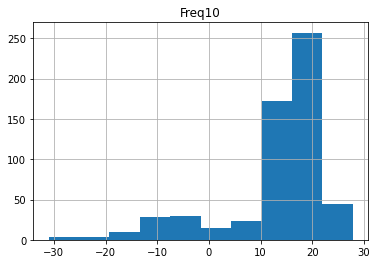

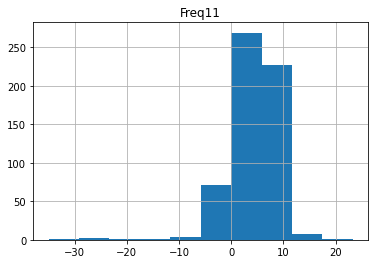

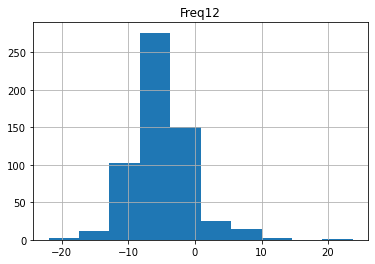

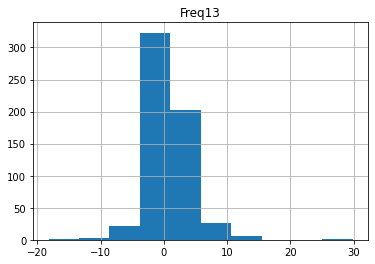

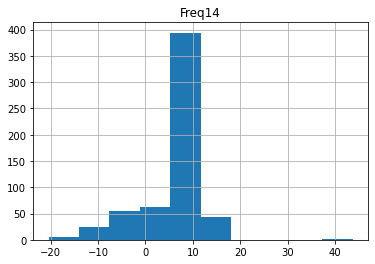

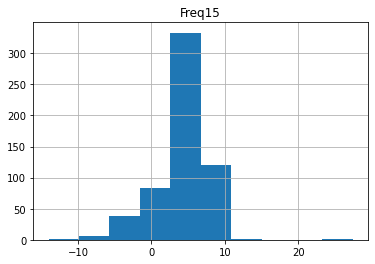

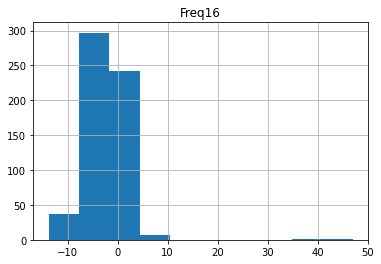

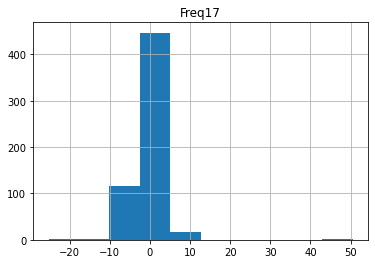

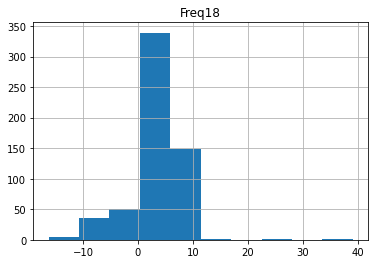

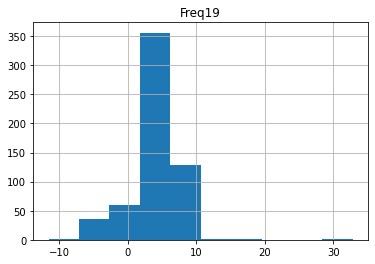

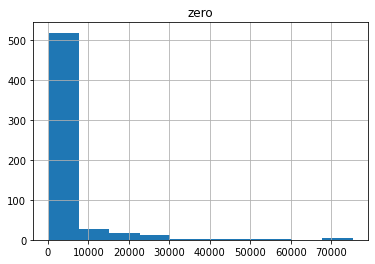

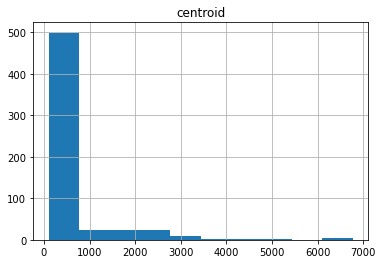

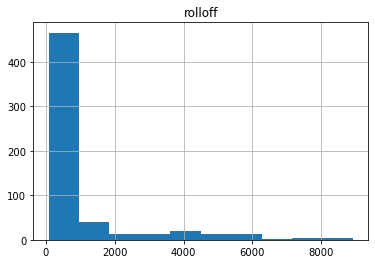

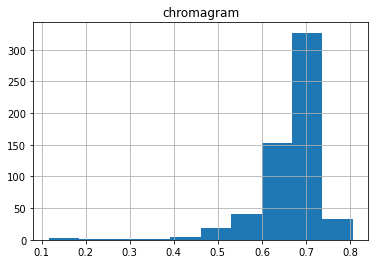

In [496]:
%%time
#Histogram for columns
for col in dataframe.columns[:-1]:
    if(col not in columnsToRemove):
        dataframe.hist(column=col)

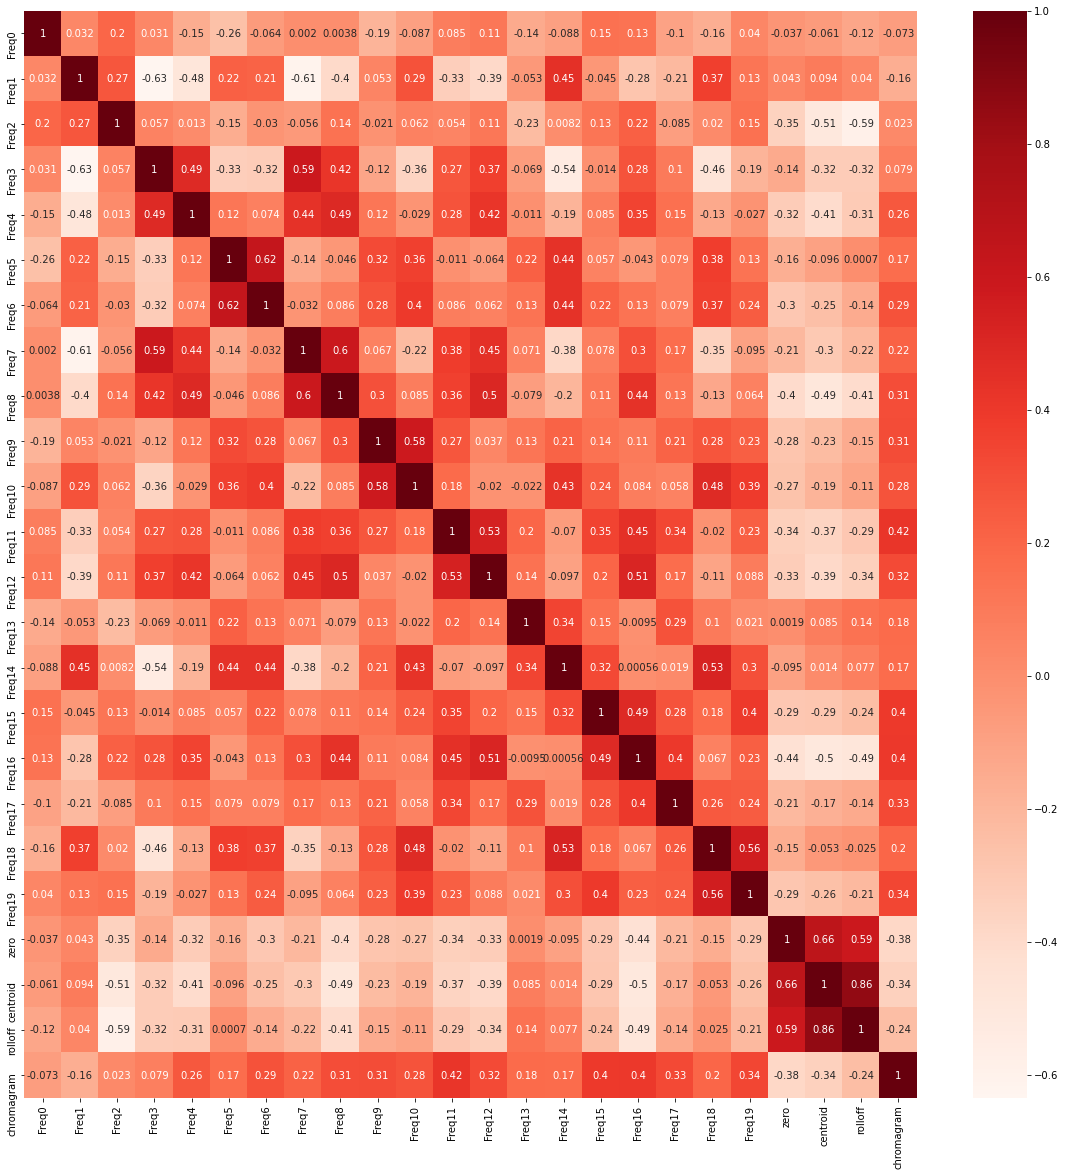

In [497]:
plt.figure(figsize=(20,20))
corr= dataframe.corr(method='kendall')
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [498]:
#Feature Selection and Remove columns based on p value test 
cols =list(dataframe.columns[:-1])
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
#drop columns which are not bringing value based on p value analysis
columnsToDrop = [item for item in dataframe.columns[:-1] if item not in cols]
dataframe = dataframe.drop(columnsToDrop, axis=1)
dataframe.head()

KeyError: "['Freq1', 'Freq8', 'Freq11', 'Freq4', 'zero', 'Freq12', 'Freq19', 'Freq7', 'Freq10', 'Freq5', 'Freq6', 'Freq15', 'Freq18', 'Freq13', 'Freq14'] not in index"

In [499]:
X=dataframe.iloc[:,0:-1]
y=dataframe.iloc[:,-1]
outputLabels=list(y.unique())
le=LabelEncoder().fit(y)
y=le.transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=31)

In [500]:
# KNN
nearest=KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
y_pred=nearest.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred, target_names=outputLabels))

0.7606837606837606
              precision    recall  f1-score   support

      normal       0.80      0.68      0.74        57
    abnormal       0.74      0.83      0.78        60

    accuracy                           0.76       117
   macro avg       0.77      0.76      0.76       117
weighted avg       0.76      0.76      0.76       117



<AxesSubplot:>

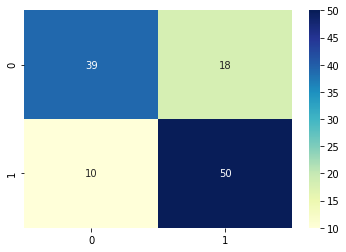

In [501]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="YlGnBu")

In [502]:
# Random Forrest
forest=RandomForestClassifier(max_depth=5,
 max_features=5,
 min_samples_split=5,
 n_estimators=1000).fit(X_train,y_train)
y_pred=forest.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred, target_names=outputLabels))

0.7777777777777778
              precision    recall  f1-score   support

      normal       0.90      0.61      0.73        57
    abnormal       0.72      0.93      0.81        60

    accuracy                           0.78       117
   macro avg       0.81      0.77      0.77       117
weighted avg       0.81      0.78      0.77       117



<AxesSubplot:>

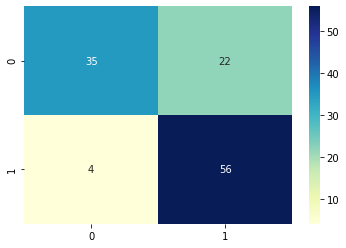

In [503]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="YlGnBu")